<a href="https://colab.research.google.com/github/daigo0927/tf-simple-metric-learning/blob/feature%2Fexample/examples/train_car196.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Metric learning in TensorFlow

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
# from tf_simple_metric_learning.layers import ArcFace, AdaCos, CircleLossCL

In [2]:
from tensorflow.keras import layers

class CosineSimilarity(layers.Layer):
    """
    Cosine similarity with classwise weights
    """
    def __init__(self, num_classes, **kwargs):
        super().__init__(**kwargs)
        self.num_classes = num_classes

    def build(self, input_shape):
        input_dim = input_shape[-1]
        self.W = self.add_weight(shape=(input_dim, self.num_classes),
                                 initializer='random_normal',
                                 trainable=True)

    def call(self, inputs):
        x = tf.nn.l2_normalize(inputs, axis=-1) # (batch_size, ndim)
        w = tf.nn.l2_normalize(self.W, axis=0)   # (ndim, nclass)
        cos = tf.matmul(x, w) # (batch_size, nclass)
        return cos


class ArcFace(layers.Layer):
    """
    Implementation of https://arxiv.org/pdf/1801.07698.pdf
    """       
    def __init__(self, num_classes, margin=0.5, scale=64, **kwargs):
        super().__init__(**kwargs)
        self.num_classes = num_classes
        self.margin = margin
        self.scale = scale

        self.cos_similarity = CosineSimilarity(num_classes)

    def call(self, inputs, training):
        # If not training (prediction), labels are ignored
        feature, labels = inputs
        cos = self.cos_similarity(feature)

        if training:
            theta = tf.acos(tf.clip_by_value(cos, -1, 1))
            cos_add = tf.cos(theta + self.margin)
    
            mask = tf.cast(labels, dtype=cos_add.dtype)
            logits = mask*cos_add + (1-mask)*cos
            logits *= self.scale
            return logits
        else:
            return cos

In [3]:
EPOCHS = 10
BATCH_SIZE = 32
IMAGE_SIZE = (256, 256)

## Inspect Cars-196 dataset
https://www.tensorflow.org/datasets/catalog/cars196

In [5]:
dataset, info = tfds.load('cars196', with_info=True, split='train')
num_classes = 196
info

/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Shuffling and writing examples to /root/tensorflow_datasets/cars196/2.0.0.incompleteJL59KB/cars196-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/cars196/2.0.0.incompleteJL59KB/cars196-test.tfrecord


Dataset cars196 downloaded and prepared to /root/tensorflow_datasets/cars196/2.0.0. Subsequent calls will reuse this data.


tfds.core.DatasetInfo(
    name='cars196',
    version=2.0.0,
    description='The Cars dataset contains 16,185 images of 196 classes of cars. The data is split into 8,144 training images and 8,041 testing images, where each class has been split roughly in a 50-50 split. Classes are typically at the level of Make, Model, Year, e.g. 2012 Tesla Model S or 2012 BMW M3 coupe.',
    homepage='https://ai.stanford.edu/~jkrause/cars/car_dataset.html',
    features=FeaturesDict({
        'bbox': BBoxFeature(shape=(4,), dtype=tf.float32),
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=196),
    }),
    total_num_examples=16185,
    splits={
        'test': 8041,
        'train': 8144,
    },
    supervised_keys=('image', 'label'),
    citation="""@inproceedings{KrauseStarkDengFei-Fei_3DRR2013,
      title = {3D Object Representations for Fine-Grained Categorization},
      booktitle = {4th International IEEE Worksh

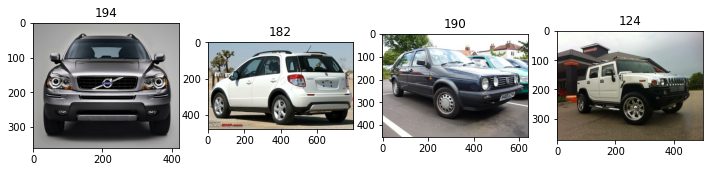

In [7]:
n_show_samples = 4

fig, axes = plt.subplots(1, n_show_samples, figsize=(12, 3))
for i, (sample) in enumerate(dataset.take(n_show_samples)):
    axes[i].set_title(sample['label'].numpy())
    axes[i].imshow(sample['image'].numpy())
plt.show()    

In [16]:
ds_train, ds_test = tfds.load('cars196', as_supervised=True, split=['train', 'test'])

def transform(image, label):
    image = tf.image.resize(image, size=IMAGE_SIZE)
    return (image, label), label

ds_train = ds_train.map(transform, num_parallel_calls=-1).shuffle(buffer_size=8000).batch(BATCH_SIZE).prefetch(buffer_size=BATCH_SIZE)
ds_test = ds_test.map(transform, num_parallel_calls=-1).batch(BATCH_SIZE)

## Build model with a metric learning layer

In [17]:
inputs = tf.keras.layers.Input([*IMAGE_SIZE, 3], dtype=tf.uint8)
x = tf.cast(inputs, dtype=tf.float32)
tf.keras.applications.efficientnet.preprocess_input(x)

net = tf.keras.applications.EfficientNetB0(include_top=False, weights='imagenet', pooling='avg')
embeds = net(x)

labels = tf.keras.layers.Input([], dtype=tf.int32)
labels_onehot = tf.one_hot(labels, depth=num_classes)

metric_layer = ArcFace(num_classes=num_classes, margin=0.5, scale=64)
logits = metric_layer([embeds, labels_onehot])

model = tf.keras.Model(inputs=[inputs, labels], outputs=logits)
model.summary()

16711680/16705208 [==============================] - 1s 0us/step
Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
tf_op_layer_Cast (TensorFlowOpL [(None, 256, 256, 3) 0           input_1[0][0]                    
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None,)]            0                                            
__________________________________________________________________________________________________
efficientnetb0 (Functional)     (None, 1280)         4049571     tf_op_layer_Cast[0][0]           
______________________

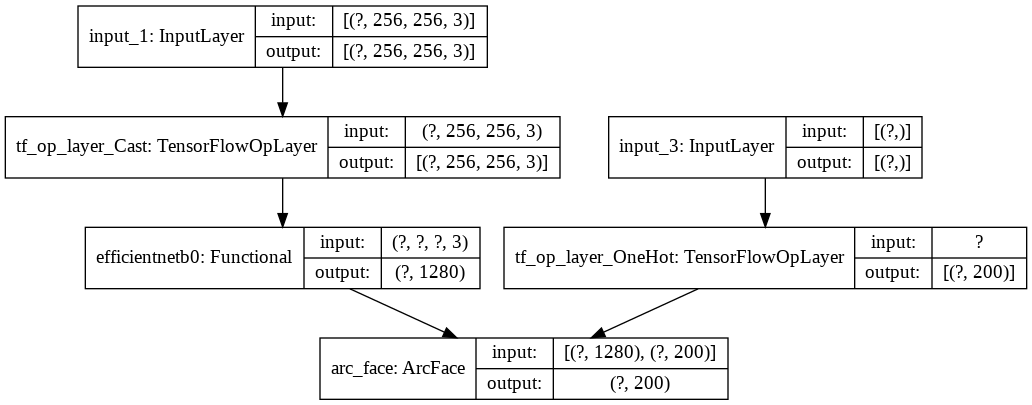

In [18]:
tf.keras.utils.plot_model(model, show_shapes=True)

## Compile and Fit

In [19]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=tf.keras.metrics.SparseCategoricalAccuracy()
)

In [20]:
model.fit(
    ds_train,
    epochs=EPOCHS,
    validation_data=ds_test,
)

Epoch 1/10
      2/Unknown - 1s 336ms/step - loss: 37.6251 - sparse_categorical_accuracy: 0.0000e+00WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.1976s vs `on_train_batch_end` time: 0.4702s). Check your callbacks.


255/255 [==============================] - 213s 835ms/step - loss: 32.6422 - sparse_categorical_accuracy: 1.2279e-04 - val_loss: 5.1613 - val_sparse_categorical_accuracy: 0.4743
Epoch 2/10
255/255 [==============================] - 208s 818ms/step - loss: 25.2073 - sparse_categorical_accuracy: 0.0263 - val_loss: 5.0509 - val_sparse_categorical_accuracy: 0.6328
Epoch 3/10
255/255 [==============================] - 208s 816ms/step - loss: 18.1547 - sparse_categorical_accuracy: 0.1686 - val_loss: 4.9288 - val_sparse_categorical_accuracy: 0.6864
Epoch 4/10
255/255 [==============================] - 208s 814ms/step - loss: 13.5781 - sparse_categorical_accuracy: 0.3384 - val_loss: 4.8707 - val_sparse_categorical_accuracy: 0.7504
Epoch 5/10
255/255 [==============================] - 208s 816ms/step - loss: 10.6557 - sparse_categorical_accuracy: 0.4456 - val_loss: 4.8188 - val_sparse_categorical_accuracy: 0.7800
Epoch 6/10
255/255 [==============================] - 207s 813ms/step - loss: 8.56